In [1]:
import numpy as np
import pandas as pd
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CSVLogger
import torch
import matplotlib.pyplot as plt

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from pytorch_forecasting.data import GroupNormalizer, NaNLabelEncoder

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("HourlySensorData.csv")
df["Datum"] = pd.to_datetime(df["Datum"])

# Nur eindeutige Messungen pro location_id und Zeitstempel behalten
df = df.drop_duplicates(subset=['location_id', 'Zeitstempel_Tag_Stunde'], keep='first')

# Daten aus 2024 nicht valide
df = df.loc[df["Datum"] < "01.01.2024"]

C:\Users\jonas\AppData\Local\Temp\ipykernel_17196\2422537688.py:1: DtypeWarning: Columns (21,22,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("HourlySensorData.csv")


In [ ]:
df["meter_id"] = df["location_id"]
df["Zeitstempel_Tag_Stunde"] = pd.to_datetime(df["Zeitstempel_Tag_Stunde"])

for part in ("month", "weekday", "hour"):
    df[part] = getattr(df["Zeitstempel_Tag_Stunde"].dt, part).astype(int)  # vorher str

# Zyklische Encodierung für verschiedene Zeitebenen
df['Stunde_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['Stunde_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['Wochentag_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['Wochentag_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['Monat_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['Monat_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df["is_holiday"] = df["Ferientyp"].notna().astype(int)  # vorher str
df["Ferientyp"]  = df["Ferientyp"].fillna("None").astype(str)
df["post_code"]  = df["post_code"].astype(str)
df["city"]       = df["city"].astype(str)

cat_cols = ["city", "post_code", "Ferientyp", "month", "weekday", "hour", "Feiertag"] # vorher mit is_holiday
for c in cat_cols:
    df[c] = pd.Categorical(df[c])               # gemeinsamer Kategorie-Pool

static_categoricals            = ["city", "post_code"]
time_varying_known_reals        = ["Zeitstempel_ns", "time_idx", "is_holiday", "month", "weekday", "hour", "Stunde_sin", "Stunde_cos", "Wochentag_sin", "Wochentag_cos", "Monat_sin", "Monat_cos", 'sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']
# time_varying_known_categoricals = ["is_holiday", "month", "weekday", "hour"]

# 2)  Beim Category-Pool Ferientyp ebenfalls weglassen
cat_cols = ["city", "post_code", "Wochentag_Name", "Bundesland", "Ferientyp"]
for c in cat_cols:
    df[c] = pd.Categorical(df[c])

static_reals = [
    "area"
]

# fehlende numerische Werte füllen
real_fill = ["cloud_cover_total", "humidity"] + static_reals
for col in real_fill:
    if col in df.columns:
        df[col] = (
            df[col]
            .ffill()
            .bfill()
            .fillna(df[col].median())
        )

try:
    df = df.drop(columns=["Unnamed: 0", "Kreis code", "Kreis name"]).drop_duplicates()
except KeyError:
    pass

# Duplikate entfernen
# Kategorische Spalten (first)
cat_cols = [
    'location_id', 'city', 'post_code', 'Datum_Messung', 'Wochentag_Name',
    'Feiertag', 'Bundesland', 'Ferientyp', 'split', 'meter_id',
    'month', 'weekday', 'hour', 'is_holiday', 'dummy_group'
]
# Gruppierspalten
group_cols = ['location_id', 'Zeitstempel_Tag_Stunde']

# Numerische Spalten (mean), außer group_cols
num_cols = df.select_dtypes(include='number').columns.difference(group_cols)

# Aggregations-Logik
agg_dict = {col: 'first' for col in cat_cols if col in df.columns}
agg_dict.update({col: 'mean' for col in num_cols if col in df.columns})

df = df.loc[df["Messwert"] != 0, :]

# Gruppierung durchführen
df = (
    df.groupby(group_cols, as_index=False)
      .agg(agg_dict)
)

df.loc[df["Messwert"] < 0, "Messwert"] = df.loc[df["Messwert"] < 0, "Messwert"] * -1

def mark_plateaus(group, min_len=100):
    change = group['Messwert'].diff().fillna(1).abs() > 1e-8
    plateau_group = change.cumsum()
    plateau_counts = plateau_group.map(plateau_group.value_counts())
    group['plateau'] = plateau_counts >= min_len
    return group

df = df.groupby('location_id', group_keys=False).apply(mark_plateaus, min_len=24)

df_train = df.loc[df["plateau"] == False]

# Werte über 2 kWh pro 15 Min extrem unrealistisch - hier bewusst als
# Threshold gesetzt um Ausreißer herauszufiltern
# Forward-fill für kurze Gaps, Interpolation für längere
max_val = 2
df_train.loc[(df_train["Messwert"] < 0) | (df_train["Messwert"] > max_val), "Messwert"] = np.nan
df_train['Messwert'] = df_train.groupby('location_id')['Messwert'].fillna(method='ffill', limit=4)
df_train['Messwert'] = df_train.groupby('location_id')['Messwert'].transform(lambda x: x.interpolate())

df_train["Zeitstempel_ns"] = df_train["Zeitstempel_Tag_Stunde"].astype("int64")

# Korrektur Pandemie-Daten
factor = df_train.loc[df_train["Zeitstempel_Tag_Stunde"] >= "01.04.2022", "Messwert"].median() / df_train.loc[df_train["Zeitstempel_Tag_Stunde"] < "01.04.2022", "Messwert"].median() - 1
df_train.loc[df_train["Zeitstempel_Tag_Stunde"] < "01.04.2022", "Messwert"] = df_train.loc[df_train["Zeitstempel_Tag_Stunde"] < "01.04.2022", "Messwert"] * (1 + factor)

# Sensor-basierte Statistiken
sensor_stats = df_train.groupby('location_id')['Messwert'].agg([
    'mean', 'std', 'min', 'max'
]).reset_index()
sensor_stats.columns = ['location_id', 'sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max']
df_train = df_train.merge(sensor_stats, on='location_id')

time_varying_unknown_reals      = ['Messwert']

# 1. Pro location_id: wie viele verschiedene Zeitstempel gibt es?
# counts = (
#     df_train
#     .dropna(subset=["Messwert"])           # Optional: nur gültige Messwerte zählen
#     .groupby("location_id")["Zeitstempel"]
#     .nunique()
# )

# 2. Filter: mindestens 130.000 verschiedene Zeitstempel
# valid_sensors = counts[counts >= 130_000].index
# df_train = df_train[df_train["location_id"].isin(valid_sensors)]

unique_times = pd.Series(df_train["Zeitstempel_Tag_Stunde"].unique()).sort_values().reset_index(drop=True)
time_map = {time: idx for idx, time in enumerate(unique_times)}
df_train["time_idx"] = df_train["Zeitstempel_Tag_Stunde"].map(time_map)

df_train["month"] = df_train["month"].astype(int)
df_train["weekday"] = df_train["weekday"].astype(int)
df_train["hour"] = df_train["hour"].astype(int)
df_train["is_holiday"] = df_train["is_holiday"].replace({"True": 1, "False": 0}).astype(int)

del sensor_stats, unique_times, time_map, factor

In [5]:
df_train = df_train.loc[:, ['Zeitstempel_Tag_Stunde', 'location_id', 'city', 'post_code',
       'Datum_Messung', 'Wochentag_Name', 'Feiertag', 'Bundesland',
       'Ferientyp', 'meter_id', 'month', 'weekday', 'hour', 'is_holiday', 'Messwert', 'Monat_cos', 'Monat_sin',
       'Stunde', 'Stunde_cos', 'Stunde_sin', 'Wochentag', 'Wochentag_cos', 'Wochentag_sin', 'area',
       'temperature_air_mean_2m', 'wind_gust_max', 'wind_speed', 'year',
       'plateau', 'Zeitstempel_ns', 'sensor_mean', 'sensor_std', 'sensor_min', 'sensor_max', 'time_idx']]

In [6]:
time_varying_unknown_reals = ['Messwert']
static_categoricals = ["city", "post_code"]

# Diese Werte sind konstant pro Sensor
time_varying_known_reals = [
    "Zeitstempel_ns", "time_idx", "is_holiday", "month", "weekday", "hour",
    "Stunde_sin", "Stunde_cos", "Wochentag_sin", "Wochentag_cos", "Monat_sin", "Monat_cos"
]

# static_reals
static_reals = ["area", "sensor_mean", "sensor_std", "sensor_min", "sensor_max"]

max_prediction_length = 24 # ein Tag
max_encoder_length = 24 * 7 # eine Woche

val_days = 365  # ein Jahr
periods_val = val_days * 24  # 24 pro Tag

training_cutoff = df_train["time_idx"].max() - periods_val

# Fill any remaining missing or infinite values in 'Messwert'
df_train['Messwert'] = df_train['Messwert'].replace([np.inf, -np.inf], np.nan)
df_train['Messwert'] = df_train['Messwert'].fillna(df_train['Messwert'].median())

training = TimeSeriesDataSet(
    df_train[df_train.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="Messwert",
    group_ids=["meter_id"],
    static_categoricals=[],
    static_reals=static_reals,
    time_varying_known_categoricals=[],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals      = time_varying_unknown_reals,
    max_encoder_length=max_encoder_length,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,  # vorher 1
    target_normalizer=GroupNormalizer(
        groups=["meter_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    time_varying_unknown_categoricals=[],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=True,
    lags={"Messwert": [6, 24, 168]}, # lag-Variablen: Messwert vor sechs Stunden / einem Tag / einer Woche
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
# Beispiel: Letzte 365 Tage im Val-Set
# cutoff_idx = df_train["time_idx"].max() - 365*4*24  # 4*24 = 96 Viertelstunden pro Tag

validation = TimeSeriesDataSet.from_dataset(
    training,
    df_train,
    min_prediction_idx=training_cutoff + 1,  # Startpunkt Val-Set
    stop_randomization=True         # Reihenfolge bleibt stabil
)

# create dataloaders for model
batch_size = 64  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 8, num_workers=0)

In [31]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\light

0.25895392894744873

In [8]:
import torch
import gc
from pytorch_forecasting import Baseline

# RAM freigeben
gc.collect()
torch.cuda.empty_cache()

# Einen Mini-Validation-Loader bauen (z.B. mit head(N))
df_sample = df_train[df_train["time_idx"] > training_cutoff].head(10000)

sample_ds = TimeSeriesDataSet(
    df_sample,
    time_idx="time_idx",
    target="Messwert",
    group_ids=["meter_id"],
    static_categoricals=[],
    static_reals=static_reals,
    time_varying_known_categoricals=[],
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals      = time_varying_unknown_reals,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_prediction_length=max_prediction_length,
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    target_normalizer=GroupNormalizer(
        groups=["meter_id"], transformation="softplus"
    ),  # use softplus and normalize by group
    time_varying_unknown_categoricals=[],
    allow_missing_timesteps=True,
    add_relative_time_idx=True,
    add_encoder_length=True,
    add_target_scales=True,
    # NaNs in categorical variables are handled by default by NaNLabelEncoder,
    # but Messwert is a real variable so we fill it explicitly above.
    # LabelEncoder=NaNLabelEncoder(add_nan=True)
)
sample_loader = sample_ds.to_dataloader(train=False, batch_size=500, num_workers=0)

actuals = torch.cat([y for x, (y, _) in iter(sample_loader)])
baseline_predictions = Baseline().predict(sample_loader)
baseline_mae = pd.Series((actuals.cpu() - baseline_predictions.cpu()).abs().numpy().flatten()).mean()
print(f"Baseline MAE: {baseline_mae:.4f}")

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\light

Baseline MAE: 0.2357


In [9]:
# configure network and trainer
from pytorch_forecasting.metrics import MAE, QuantileLoss
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import optuna

import pickle

with open(r"G:\Meine Ablage\optuna_runs\test_study.pkl", "rb") as fin:
    study = pickle.load(fin)

pl.seed_everything(42)

# Wo speichern?
ckpt_path = "/checkpoints/best_tft.ckpt"

# ModelCheckpoint-Callback
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",   # was überwacht werden soll
    mode="min",           # je kleiner, desto besser
    save_top_k=1,         # nur das beste Modell behalten
    dirpath="tft_hourly/checkpoints",  # Speicherort
    filename="best_tft"   # Dateiname ohne .ckpt
)

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor("epoch")  # log the learning rate
logger = CSVLogger("logs_hourly_csv")  # logging results to a csv file (tensorboard not compatible with python 3.13)

trainer = pl.Trainer(
    max_epochs=10,
    precision='32',
    accelerator="auto",  # auto = Let lightning automatically select the accelerator
    devices="auto",  # auto = Removed explicit devices setting
    # weights_summary="top",
    gradient_clip_val=study.best_trial.params["gradient_clip_val"],
    limit_train_batches=100,  # comment in for training, running validation every 30 batches
    limit_val_batches=40,
    # fast_dev_run=True,  # comment in to check that network or dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    logger=logger,
    log_every_n_steps=10,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=study.best_trial.params["learning_rate"],
    hidden_size=study.best_trial.params["hidden_size"],
    attention_head_size=study.best_trial.params["attention_head_size"],
    lstm_layers=1,
    dropout=study.best_trial.params["dropout"],
    hidden_continuous_size=study.best_trial.params["hidden_continuous_size"],
    optimizer="adamw",  # or adam
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),     # or QuantileLoss()
    # max_encoder_length = max_encoder_length,
    # log_interval=1,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Number of parameters in network: 1396.3k


In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
)

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:658: Checkpoint directory C:\Users\jonas\Desktop\Studium\Master\SS 2025\Anwendungsfelder Business Analytics\Training\tft_hourly\checkpoints exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 2.0 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 121 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 100/100 [07:31<00:00,  0.22it/s, v_num=2, train_loss_step=0.0813, val_loss=0.103, train_loss_epoch=0.0854] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 100/100 [07:32<00:00,  0.22it/s, v_num=2, train_loss_step=0.0813, val_loss=0.103, train_loss_epoch=0.0854]


In [11]:
ckpt_path = "tft_hourly/checkpoints/best_tft.ckpt"
best_model = TemporalFusionTransformer.load_from_checkpoint(ckpt_path)
tft = best_model
del best_model

device = "cuda" if torch.cuda.is_available() else "cpu"
tft = tft.to(device)

import gc
gc.collect()

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


0

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pytorch_forecasting.metrics import SMAPE

# Subset vom val_dataloader

ckpt_path = "tft_hourly/checkpoints/best_tft.ckpt"
best_model = TemporalFusionTransformer.load_from_checkpoint(ckpt_path)
tft = best_model
del best_model

device = "cuda" if torch.cuda.is_available() else "cpu"
tft = tft.to(device)

tft = tft.float()
tft.eval()

location_id_labels = df_train["location_id"].unique()

first_10_sequence_ids = np.unique(val_dataloader.dataset.data['groups'].flatten().numpy())[:10]
first_10_location_ids = location_id_labels[first_10_sequence_ids]

# 2. Ursprungs-DataFrame filtern (z. B. df_train oder val_df)
df_subset = df_train[df_train['location_id'].isin(first_10_location_ids)]  # oder 'meter_id'

# 3. Neues Dataset und DataLoader erstellen
subset_dataset = TimeSeriesDataSet.from_dataset(validation, df_subset, stop_randomization=True)
subset_val_dataloader = subset_dataset.to_dataloader(train=False, batch_size=512, num_workers=8)

all_preds = []
all_actuals = []

with torch.no_grad():
    for x, (y, _) in subset_val_dataloader:
        x = {k: v.to(device) for k, v in x.items()}
        y = y.to(device)
        # Modell aufrufen!
        batch_pred_output = tft(x)
        batch_pred = batch_pred_output.prediction  # shape: [batch, prediction_length, n_quantiles]
        # print(batch_pred, "\n")

        median_idx = batch_pred.shape[2] // 2
        batch_pred_median = batch_pred[:, :, median_idx]
        # print(batch_pred_median, "\n")

        all_preds.append(batch_pred_median.detach().cpu().flatten())
        all_actuals.append(y.detach().cpu().flatten())

# Stapel zu Vektor verbinden
preds_flat = torch.cat(all_preds).numpy()
actuals_flat = torch.cat(all_actuals).numpy()

# Fehlermaße berechnen
mse  = mean_squared_error(actuals_flat, preds_flat)
rmse = mse ** 0.5
mae  = mean_absolute_error(actuals_flat, preds_flat)
r2   = r2_score(actuals_flat, preds_flat)

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))

smape_val = smape(actuals_flat, preds_flat)

medae = np.median(np.abs(actuals_flat - preds_flat))

print(f"MSE:    {mse:.4f}")
print(f"RMSE:   {rmse:.4f}")
print(f"MAE:    {mae:.4f}")
print(f"MedAE: {medae:.4f}")
print(f"SMAPE:  {smape_val:.2f}%")
print(f"R^2:    {r2:.4f}")

c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


MSE:    0.0580
RMSE:   0.2408
MAE:    0.1372
MedAE: 0.0684
SMAPE:  39.48%
R^2:    0.8467


In [13]:
import numpy as np
from sklearn.metrics import r2_score

# Annahme: preds_flat und actuals_flat sind schon angelegt wie vorher

# Grundlegende Kennzahlen zum Target
mean_val = np.mean(actuals_flat)
std_val  = np.std(actuals_flat)
min_val  = np.min(actuals_flat)
max_val  = np.max(actuals_flat)
print(f"Target: mean={mean_val:.4f}, std={std_val:.4f}, min={min_val:.4f}, max={max_val:.4f}")

# 2) Relativer MAE
rel_mae = mae / mean_val * 100  # in Prozent
print(f"Relativer MAE: {rel_mae:.1f} %")

# 3) R²‑Score
r2 = r2_score(actuals_flat, preds_flat)
print(f"R²: {r2:.3f}")

Target: mean=0.6364, std=0.6152, min=0.0000, max=2.0000
Relativer MAE: 21.6 %
R²: 0.847


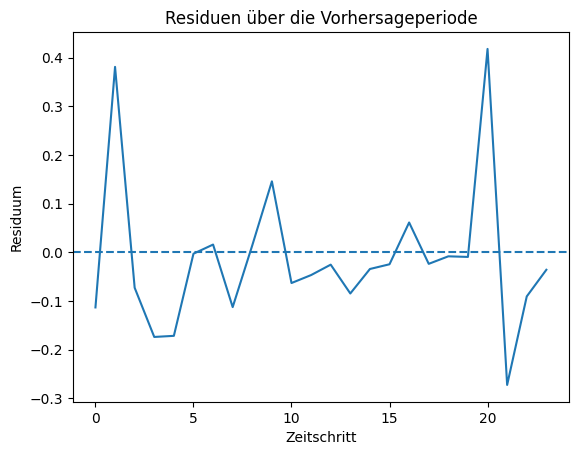

In [117]:
# %% 2) Residuen über die Zeit
residuals = true_series - q_series[:, 3].numpy()

plt.figure()
plt.plot(residuals)
plt.axhline(0, linestyle="--")
plt.title("Residuen über die Vorhersageperiode")
plt.xlabel("Zeitschritt")
plt.ylabel("Residuum")
plt.show()

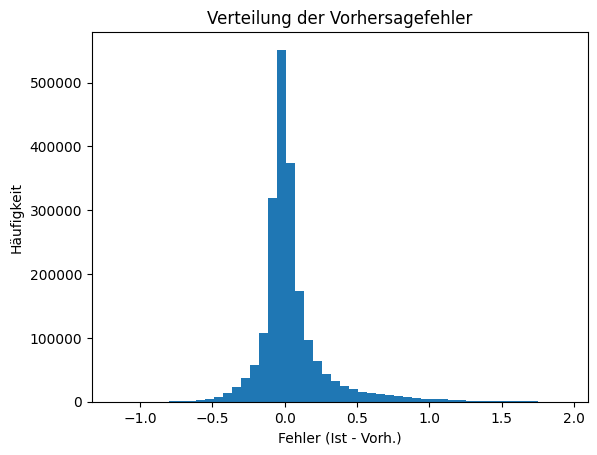

In [16]:
# Fehler-Verteilung (Histogramm)
all_errors = (torch.cat(all_actuals).cpu().numpy().flatten() - torch.cat(all_preds).cpu().numpy().flatten())

plt.figure()
plt.hist(all_errors, bins=50)
plt.title("Verteilung der Vorhersagefehler")
plt.xlabel("Fehler (Ist - Vorh.)")
plt.ylabel("Häufigkeit")
plt.show()

MAE für die Serie: 0.1001


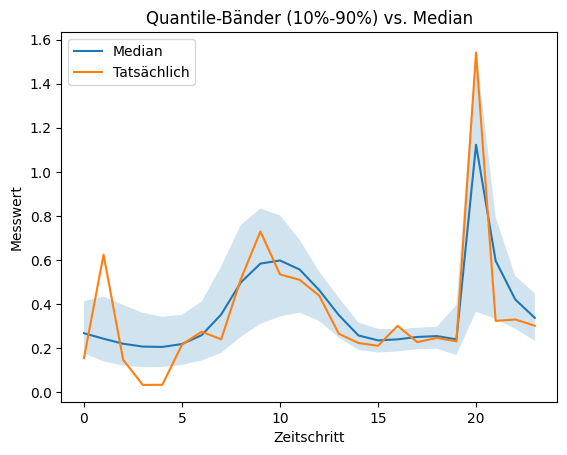

In [ ]:
# %% 4) Quantile-Bänder (z.B. 10%, 50%, 90%)
import torch
import matplotlib.pyplot as plt

location_id_labels = df_train["location_id"].unique()

first_10_sequence_ids = np.unique(val_dataloader.dataset.data['groups'].flatten().numpy())[:10]
first_10_location_ids = location_id_labels[first_10_sequence_ids]

# 2. Ursprungs-DataFrame filtern (z. B. df_train oder val_df)
df_subset = df_train[df_train['location_id'].isin(first_10_location_ids)]  # oder 'meter_id'

# 3. Neues Dataset und DataLoader erstellen
subset_dataset = TimeSeriesDataSet.from_dataset(validation, df_subset, stop_randomization=True)
subset_val_dataloader = subset_dataset.to_dataloader(train=False, batch_size=512, num_workers=8, persistent_workers=True)

# gewünschte Quantile
quantiles = [0.1, 0.5, 0.9]

# Vorhersage aller Quantile abfragen
tft.eval()
with torch.no_grad():
    preds_q = tft.predict(
        subset_val_dataloader,
        mode="quantiles",
        mode_kwargs={"quantiles": quantiles},
    ).cpu()  # -> Tensor [n_samples, prediction_length, n_quantiles]
    
series_idx = 1230
q_series   = preds_q[series_idx]           # [prediction_length, n_quantiles]
true_series = actuals_all[series_idx].numpy()

lower  = q_series[:, 1].numpy()
median = q_series[:, 3].numpy()
upper  = q_series[:, 4].numpy()

mae_series = pd.Series(true_series - q_series[:, 3].numpy()).abs().mean()
print(f"MAE für die Serie: {mae_series:.4f}")

plt.figure()
plt.plot(median, label="Median")
plt.fill_between(range(len(median)), lower, upper, alpha=0.2)
plt.plot(true_series, label="Tatsächlich")
plt.legend()
plt.title("Quantile-Bänder (10%-90%) vs. Median")
plt.xlabel("Zeitschritt")
plt.ylabel("Messwert")
plt.show()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\jonas\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_forecasting\models\base\_base_model.py:122: UserWarning: Not all dimensions are equal for tensors shapes. Example tensor torch.Size([512, 24, 4, 168]). Returning list instead of torch.Tensor.
  warnings.warn(


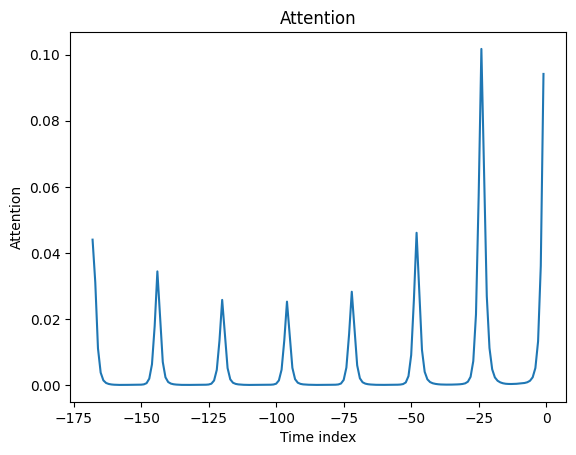

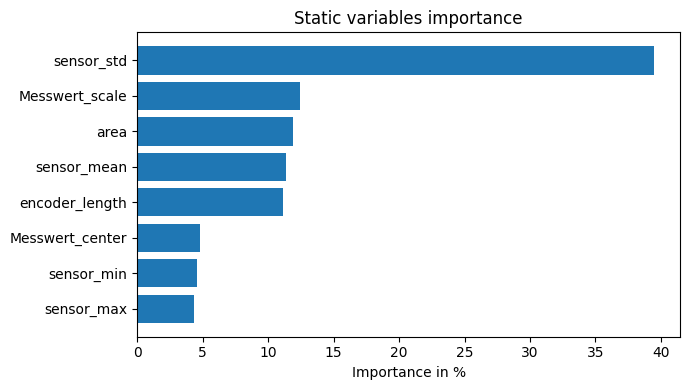

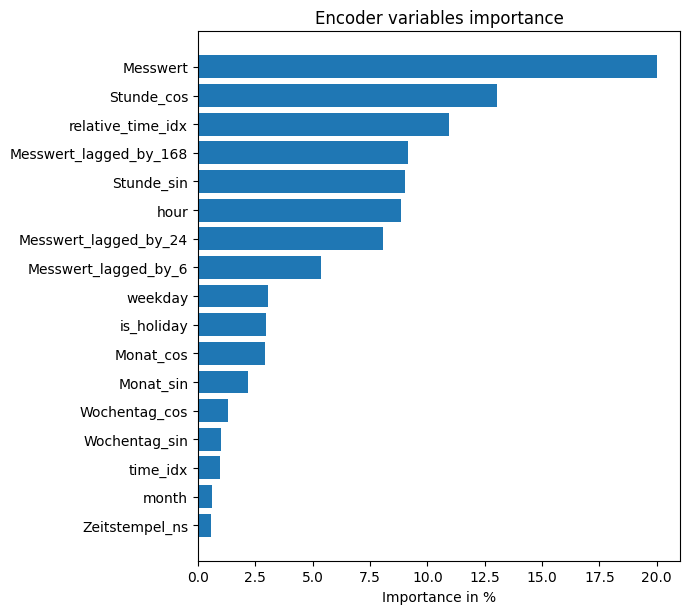

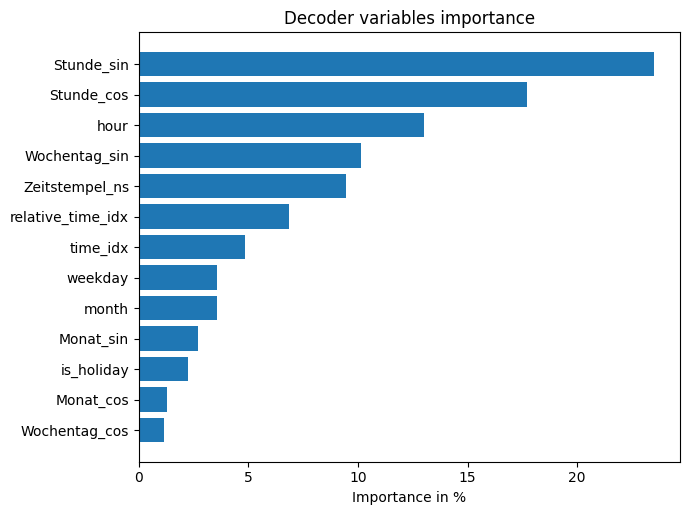

In [118]:
output = tft.predict(subset_val_dataloader, mode="raw", return_x=True)

# Prediction-Objekt wie ein Tupel behandeln und erstes Element nehmen
raw_predictions = output[0]

interpretation = tft.interpret_output(raw_predictions, reduction="sum")

tft.plot_interpretation(interpretation)
import matplotlib.pyplot as plt
plt.show()